In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:

cfg = {'title': "proxy-response variance / sft5 probability / cosine / 10'%'sample / fine_grained", 'output_name': "sft5_prob_proxy_var_cosine", "oepn_json": "/home/eunwon/Dataset-Cartography/src/results/sft5_prob_proxy_var_cosine_fine_graind.jsonl", }
#cfg = {'title': "proxy-response variance / sft5 probability / cosine / 10'%'sample / helpfulness", 'output_name': "sft5_prob_proxy_var_cosine", "oepn_json": "/home/eunwon/Dataset-Cartography/src/results/sft5_prob_proxy_var_cosine.jsonl", }
cfg = {'title': "proxy / st / cosine / 10% sample ", 'output_name': "rouge_proxy_var_cosine", "oepn_json": "../../results/5sft_proxy_kl.jsonl", }

def load_processed_data(open_json):
    with open(open_json, 'r') as file:
        data = [json.loads(line) for line in file.readlines()]
    return data

data = load_processed_data(cfg["oepn_json"])

In [5]:
scores = []
gpt_scores = []

def sigmoid(x): return 1 / (1 + np.exp(-x))
                            
scores = [ item['scores'] for item in data]
scores_avg = [np.tanh(np.mean(prob)) for prob in scores]
#scores_avg = [(gpt_scores[i]/np.mean(scores[i])) for i in range(len(data))]
score_variance = [item['score_variance'] for item in data]
correlation = [item['correlation'] for item in data]
instruction = [item['instruction'] for item in data]
gpt_inference = [item['gpt_inference'] for item in data]

response = []
for item in data:
    response_str = ""
    for i in range(len(item['completions'])):
        response_str += item['completions'][i]['response']
        if i != 3:
            response_str += ", "
    response.append(response_str)


combined_df = pd.DataFrame({
    'score_avg': scores_avg,
    'scores': scores,
    'score_variance': score_variance,
    'correlation': correlation,
    'instruction': instruction,
    'response': response,
    'gpt_inference': gpt_inference
})

combined_df.info()
combined_df.describe()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_avg       1950 non-null   float64
 1   scores          1950 non-null   object 
 2   score_variance  1950 non-null   float64
 3   correlation     1949 non-null   float64
 4   instruction     1950 non-null   object 
 5   response        1950 non-null   object 
 6   gpt_inference   1950 non-null   object 
dtypes: float64(3), object(4)
memory usage: 106.8+ KB


,score_avg,scores,score_variance,correlation,instruction,response,gpt_inference
0,0.139591,"[0.054620981216430664, 0.32596880197525024, 0....",0.015797,0.086496,Change the vowel sound of the following word t...,"The new word is ""spoonerism"", which is the act...","If you change the vowel sound in ""spoon,"" you ..."
1,0.401934,"[0.4879073202610016, 0.44519972801208496, 0.43...",0.003140,0.958886,Imagine you are tasked with creating a virtual...,Hello! I'm here to help you with your question...,To calculate the immersive index using the for...
2,0.273198,"[0.35573825240135193, 0.30449211597442627, 0.2...",0.002811,0.957389,Can you provide a well-curated and diversified...,Title: 5 Must-Read Books for Teenagers: A Well...,Certainly! Below is a carefully selected and d...
3,0.027192,"[0.02260626293718815, 0.019590036943554878, 0....",0.000044,0.983251,Generate a creative title for a podcast episode.,"""Harmonious Horizons: Exploring the Symphony o...","""Unveiling the Extraordinary: Stories That Ins..."
4,0.248083,"[0.11030548065900803, 0.3064965605735779, 0.30...",0.006878,0.994170,How can I enhance the precision of a MATLAB-ba...,"Yes, I can assist you in developing an algorit...",Enhancing the precision of a MATLAB-based algo...


The minimum cosine similarity in the filtered dataframe is: 0.0


/tmp/ipykernel_1141012/2057266685.py:39: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(8, 6))
/tmp/ipykernel_1141012/2057266685.py:46: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Figure size 800x600 with 0 Axes>

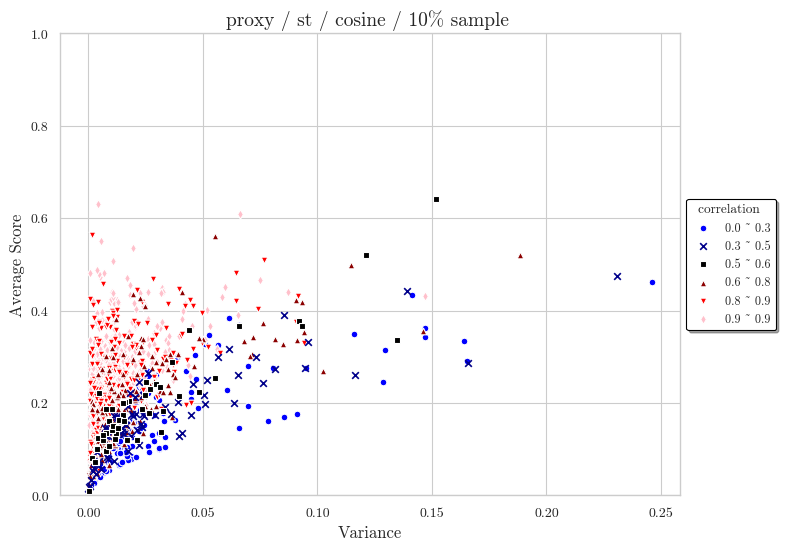

In [8]:
filtered_df = combined_df[combined_df['correlation'] >= 0]
filtered_df = filtered_df[filtered_df['correlation'] < 0.95]
min_cosine_similarity = filtered_df['correlation'].min()


threshold = 0.1
near_zero_df = filtered_df[
    (filtered_df['score_variance'].abs() < threshold) & 
    (filtered_df['score_avg'].abs() < threshold)
]


print(f"The minimum cosine similarity in the filtered dataframe is: {min_cosine_similarity}")

# Define bins, colors, and shapes based on 'correlation
# 
# '
cosine_bins = [0.0, 0.3, 0.5, 0.6, 0.8, 0.9, 0.95]

# Generate color gradient: blue → dark blue → black → dark red → red
cmap = ListedColormap(['blue', 'darkblue', 'black', 'darkred', 'red'])
gradient_colors = [cmap(i / 4) for i in range(5)]  # 5 gradient colors
gradient_colors.append('pink')  # Add red for the last bin
colors = {i + 1: gradient_colors[i] for i in range(6)}

# Define shapes for each bin
shapes = {1: 'o', 2: 'x', 3: 's', 4: '^', 5: 'v', 6: 'd'}

# Classify 'correlation' into bins
filtered_df['cosine_bin'] = pd.cut(
    filtered_df['correlation'], 
    bins=cosine_bins,
    labels=[1, 2, 3, 4, 5, 6],  # Correspond to colors and shapes
    include_lowest=True
)

# Initialize plot
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with varying colors and shapes
for c in filtered_df['cosine_bin'].unique():
    if pd.isna(c):  # Skip NaN bins
        continue
    subset_df = filtered_df[filtered_df['cosine_bin'] == c]
    ax.scatter(
        subset_df['score_variance'], 
        subset_df['score_avg'], 
        c=[colors[int(c)]],  # Match the color to the cosine bin
        marker=shapes[int(c)],  # Match the shape to the cosine bin
        edgecolors='white',  # Add black border to points
        label=f'{cosine_bins[int(c)-1]:.1f} ~ {cosine_bins[int(c)]:.1f}', 
        alpha=1.0
    )

# Sort the legend manually by the cosine_bin order
handles, labels = ax.get_legend_handles_labels()  # Get current legend handles and labels

# Sort handles and labels by the numeric range in labels
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: float(x[1].strip().split("~")[0]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# LaTeX 스타일 텍스트 활성화
plt.rcParams['font.family'] = 'cmr10'

# Axis labels and legend
plt.xlabel('Variance')
plt.ylabel('Average Score')
plt.ylim(0, 1)  # Set the y-axis limits based on cfg

plt.title(cfg['title'])
ax.legend(
    sorted_handles,
    sorted_labels,
    title="correlation ", 
    loc="center left",       # 범례를 왼쪽 중앙에 앵커링
    bbox_to_anchor=(1.0, 0.5),  # 그래프의 오른쪽에 위치하도록 설정
    frameon=True,            # 박스 활성화
    edgecolor='black',       # 테두리 색상
    framealpha=1.0,           # 테두리 투명도
    shadow=True
)

plt.grid(True)

# Add colorbar for full cosine similarity range
scatter = ax.scatter(
    filtered_df['score_variance'], 
    filtered_df['score_avg'], 
    c=filtered_df['correlation'], 
    cmap='viridis', 
    alpha=0
)
plt.savefig(f"../../results/{cfg['output_name']}.png")
plt.show()

/tmp/ipykernel_1141012/2603095090.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df
/home/eunwon/.conda/envs/carto/lib/python3.9/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/home/eunwon/.conda/envs/carto/lib/python3.9/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


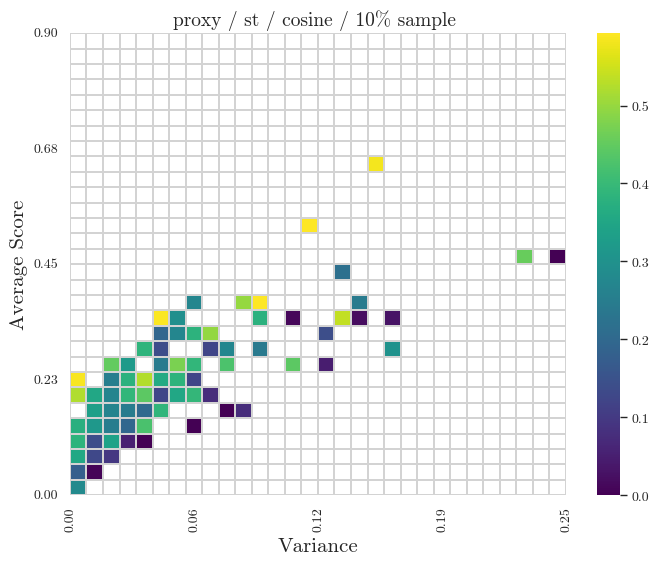

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    style='whitegrid',
    context='paper',  
    font='cmr10',   # LaTeX 느낌 폰트
    rc={
        "font.size": 12,         # 기본 폰트 크기
        "axes.titlesize": 14,    # 제목 폰트 크기
        "axes.labelsize": 12,    # 축 라벨 폰트 크기
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # 'text.usetex': True,   # 실제 LaTeX로 렌더링하려면 이 옵션도
    }
)

# 1) x, y축에 대한 bin 경계 만들기
x_edges = np.linspace(0, 0.25, 31)  # 0~1 구간을 30등분
y_edges = np.linspace(0, 0.9, 31)

# 2) score_variance, score_avg를 각각 pd.cut으로 나누고,
#    그룹별로 cosine_similarity 평균을 구한다.
binned_df = (
    filtered_df
    .assign(
      x_bin=pd.cut(filtered_df['score_variance'], bins=x_edges),
      y_bin=pd.cut(filtered_df['score_avg'],      bins=y_edges)
    )
    .groupby(['x_bin','y_bin'])['correlation']
    .mean()
    .reset_index()
)

# 3) pivot_table로 2차원 형태 만들기
heatmap_data = binned_df.pivot(index='y_bin', columns='x_bin', values='correlation')

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_data,
    cmap='viridis',
    cbar=True,
    square=False,    # True 면 가로세로가 같은 길이가 되므로, 상황에 따라 False로
    linewidths=0.05,
    linecolor='lightgray',
)

# y축이 위에서 아래로 그려지므로, 0을 “아래”로 배치하기 위해 뒤집어줍니다
ax.invert_yaxis()

# x축, y축 라벨 직접 세팅 (여기서는 bin 테이블에 맞춰 단순히 off)
# x축, y축의 모든 틱을 없애기
x_divisions = 4
y_divisions = 4

# (1) X축 틱 설정
#     0~0.25 범위를 4등분하면 0.00, 0.06..., 0.12..., ..., 0.25 총 5지점
x_ticks = np.linspace(0, 0.25, x_divisions + 1)
xtick_positions = [(val / 0.25)*30 for val in x_ticks]  # 0~0.25가 0~30 인덱스로 매핑
xtick_labels = [f'{val:.2f}' for val in x_ticks]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# (2) Y축 틱 설정
#     0~0.9 범위를 4등분하면 0.00, 0.225, 0.45, 0.675, 0.90 총 5지점
y_ticks = np.linspace(0, 0.9, y_divisions + 1)
ytick_positions = [(val / 0.9)*30 for val in y_ticks]   # 0~0.9가 0~30 인덱스로 매핑
ytick_labels = [f'{val:.2f}' for val in y_ticks]

ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)
ax.grid(False)

# 전체 X, Y 축 범위(데이터 실제 범위)에 맞추고 싶다면:
# (pivot 테이블은 카테고리형 인덱스/컬럼이므로, 아래와 같이 수동 조정)
ax.set_xlim(0, len(x_edges) - 1)  # x_edges가 31개면 실제로는 30개 bin
ax.set_ylim(0, len(y_edges) - 1)

plt.xlabel('Variance', fontsize=15)
plt.ylabel('Average Score', fontsize=15)
plt.title(f"{cfg['title']}")

plt.show()